# Klasyfikacja toksycznych komentarzy



# Cel projektu

Celem projektu jest klasyfikacja toksycznych komentarzy, które zostały
zaczerpnięte z forum edytorskiego anglojęzycznej Wikipedii. Na podstawie treści komentarzy
stworzony zostanie efektywny klasyfikator, który będzie przypisywał, czy dany komentarz jest obelgą, groźbą
czy też zniewagą.

# Charakterystyka zbiorów treningowego i testowego

## Podstawowe informacje

Zbiór danych pochodzi z *The Wikipedia Corpus*. Zbiór danych zawiera  komentarze pochodzących z sekcji edytorskich artykułów na anglojęzycznej *Wikipedii*. W ramce danych znajdziemy 8 kolumn:

*    `id` - unikalny ciąg znaków przypisany każdemu komentarzowi,
*   `comment_text` - treść komentarza,

Dalsze kolumny będą mieć wartości binarne i będą nam określały, czy dany komentarz jest klasyfikowany jako:

* `toxic`,
* `severe_toxic`,
* `obscene`,
* `threat`,
* `insult`,
* `identity_hate`,

gdzie wartość 1 w danej kolumnie będzie oznaczała, że dany komentarz został otagowany jako dany typ toksycznego komentarza, w przeciwnym przypadku w kolumnie będzie znajdywała się wartość 0. W sytuacji, kiedy wszystkie wartości są równe 0, komentarz nie jest toksyczny. 

Załadujemy podstawowe biblioteki do pracy z danymi:

In [116]:
import pandas as pd
import numpy as np
from os import path
import scipy.stats as stats

oraz pakiety do tworzenia różnych wizualizacji:

In [117]:
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

Załadowanie i podstawowe informacje o zbiorze treningowym.

In [121]:
train = pd.read_csv('train.csv') #wczytanie danych
train_values = train.values #wartości do dalszej pracy

print('                                       Podstawowe informacje\n')
print('Liczba rekordów w zbiorze treningowym to:', train.shape[0])
print('Liczba wartości brakujących w zbiorze treningowym to:', train.isnull().values.any().sum()) 
print('Liczba unikalnych wartości w kolumnie id:', train['id'].nunique())
print('Typy danych znajdujących się w kolumnach to:\n\n', train.dtypes)

                                       Podstawowe informacje

Liczba rekordów w zbiorze treningowym to: 159571
Liczba wartości brakujących w zbiorze treningowym to: 0
Liczba unikalnych wartości w kolumnie id: 159571
Typy danych znajdujących się w kolumnach to:

 id               object
comment_text     object
toxic             int64
severe_toxic      int64
obscene           int64
threat            int64
insult            int64
identity_hate     int64
dtype: object


Wygenerujmy 7 losowych obserwacji ze zbioru treningowego.

In [199]:
train.sample(7)

comment_text  toxic  \
123744  The article Rick Eye has been speedily deleted...      0   
109725  I believe it is mostly kayfabe. TNA just wants...      0   
56497   Looks like it is my spaces. I guess I will sta...      0   
107880  Image:Arkham_20_years.jpg\nI have tagged Image...      0   
151686  "\nSo, congratulating someone for enjoying the...      0   
18746   New Complaint\nHi,\n\nperhaps you can help me ...      0   
5429    "\n\n Canuckster's user & talk pages \n\nI thi...      0   

        severe_toxic  obscene  threat  insult  identity_hate  
123744             0        0       0       0              0  
109725             0        0       0       0              0  
56497              0        0       0       0              0  
107880             0        0       0       0              0  
151686             0        0       0       0              0  
18746              0        0       0       0              0  
5429               0        0       0       0              0

## Niezbalansowanie zbioru

Sprawdźmy podstawowe statystyki dotyczące kolumn mających typ numeryczny za pomocą funkcji *describe*.

In [123]:
train.describe()

toxic   severe_toxic        obscene         threat  \
count  159571.000000  159571.000000  159571.000000  159571.000000   
mean        0.095844       0.009996       0.052948       0.002996   
std         0.294379       0.099477       0.223931       0.054650   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.000000       0.000000       0.000000       0.000000   
max         1.000000       1.000000       1.000000       1.000000   

              insult  identity_hate  
count  159571.000000  159571.000000  
mean        0.049364       0.008805  
std         0.216627       0.093420  
min         0.000000       0.000000  
25%         0.000000       0.000000  
50%         0.000000       0.000000  
75%         0.000000       0.000000  
max         1.000000       1.000000

Patrząc na średnią, która jest bardzo mała we wszystkich kategoriach, możemy mieć przypuszczenie, że większość danych w naszej bazie nie jest toksyczna (tj. średnia to suma 1 w danej kolumnie przez ilość wszystkich komentarzy, jeśli jest ona mała to znaczy, że proporcja 1 do ilości 0 i 1  jest również mała).

Sprawdźmy jaki procent wszystkich obserwacji stanowią komentarze toksyczne, sprawdzimy też jak wygląda przykład takiego komentarza.

In [124]:
print('Procent komentarzy, które nie są toksyczne to',
      (np.sum(train_values[:,2:], axis=1)==0).sum()/train.shape[0]*100)
print('Przykład toksycznego komentarza:', train[np.sum(train_values[:,2:], axis=1)>0]['comment_text'].sample(1))
print('Przykład nietoksycznego komentarza:', train[np.sum(train_values[:,2:], axis=1)==0]['comment_text'].sample(1))

Procent komentarzy, które nie są toksyczne to 89.83211235124176
Przykład toksycznego komentarza: 38427    Nazi.  You can delete my talk page, but i do i...
Name: comment_text, dtype: object
Przykład nietoksycznego komentarza: 134095    Hello, you are right that 3/16th Punjabs left ...
Name: comment_text, dtype: object


Zauważmy, że w przypadku ~90% komentarzy nietoksycznych mamy do czynienia ze sporym niezbalansowaniem. Przedstawmy teraz liczbę komentarzy przypisanych do danej klasy za pomocą wykresu słupkowego.

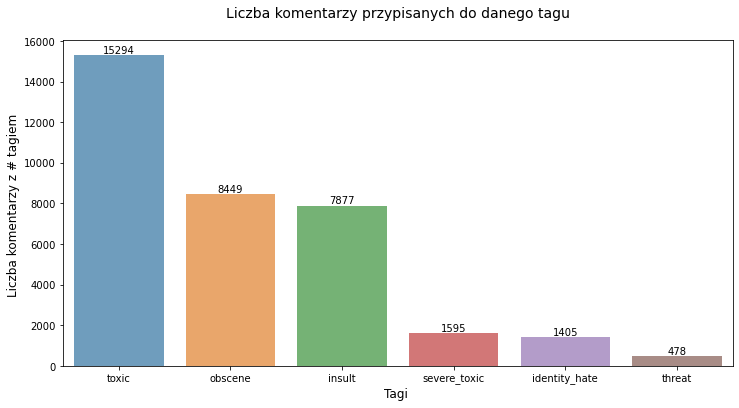

In [125]:
#Generowanie wykresu
x = train.iloc[:,2:].sum().sort_values(ascending = False) #przesumujmy liczbę 1 w kolumnach 2:
#wykres 
plt.figure(figsize = (12,6)) 
ax = sns.barplot(x = x.index, y = x.values, alpha = 0.7)
plt.title('Liczba komentarzy przypisanych do danego tagu\n', fontsize = 14)
plt.xlabel('Tagi ', fontsize = 12)
plt.ylabel('Liczba komentarzy z # tagiem ', fontsize=12)
#dodanie dokładnej liczby 
bars = ax.patches #pobieramy nasze słupki
labels = x.values
for bar, label in zip(bars, labels): #zip agreguje w tuple

    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, label, ha='center', va='bottom')
    #dopisujemy tekst - (x + 1/2 szerokości słupka, wysokość słupka + 5), label, który będzie wartością naszego słupka;
    #położenie poziome - horizontal - wyśrodkowowane, i tekst wertykalnie na dole

plt.show()

Po wartościach możemy zauważyć, że mamy do czynienia z tym, że dany toksyczny komentarz może być otagowany więcej niż jednym tagiem. Ponadto zauważmy, że również klasy są między sobą niezbalansowane.

In [140]:
multitags = train.iloc[:,2:].sum(axis=1).value_counts() #sumujemy wartości w wierszach, zliczamy ile jest danej wartości
multitags.index = multitags.index.astype(int) #konwertujemy float do int
df = pd.DataFrame(multitags).reset_index()
df.columns = ['liczba tagów', 'liczba toksycznych komentarzy z # ilością tagów']
display(df.sort_values(by='liczba tagów').reset_index().drop(columns='index'))

liczba tagów  liczba toksycznych komentarzy z # ilością tagów
0             0                                           143346
1             1                                             6360
2             2                                             3480
3             3                                             4209
4             4                                             1760
5             5                                              385
6             6                                               31

Mając do czynienia z multitagowaniem warto byłoby przyjrzeć się, które z tagów są ze sobą powiązane, mając jednak na uwadze, że tagowanie wykonywały różne osoby, co może rzutować na wyniki.

### Histogramy długości komentarzy

In [141]:
train_help = train.copy()
train_help['length'] = train_help['comment_text'].apply(len) #dodajemy kolumnę z długością poszczególnych komentarzy

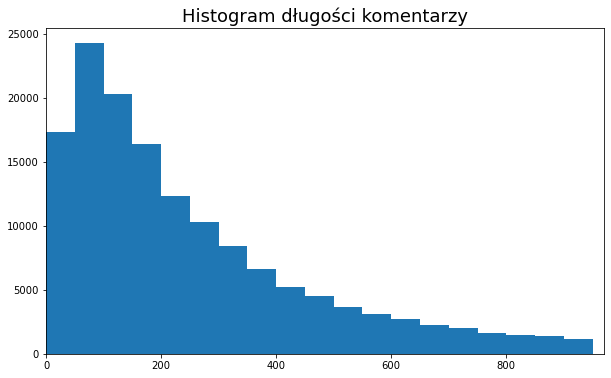

In [142]:
plt.figure(figsize=(10,6))
plt.hist(train_help['length'],  bins=np.arange(0,1000,50))
plt.xlim([0, 970])
plt.title("Histogram długości komentarzy", fontsize=18)
plt.show()

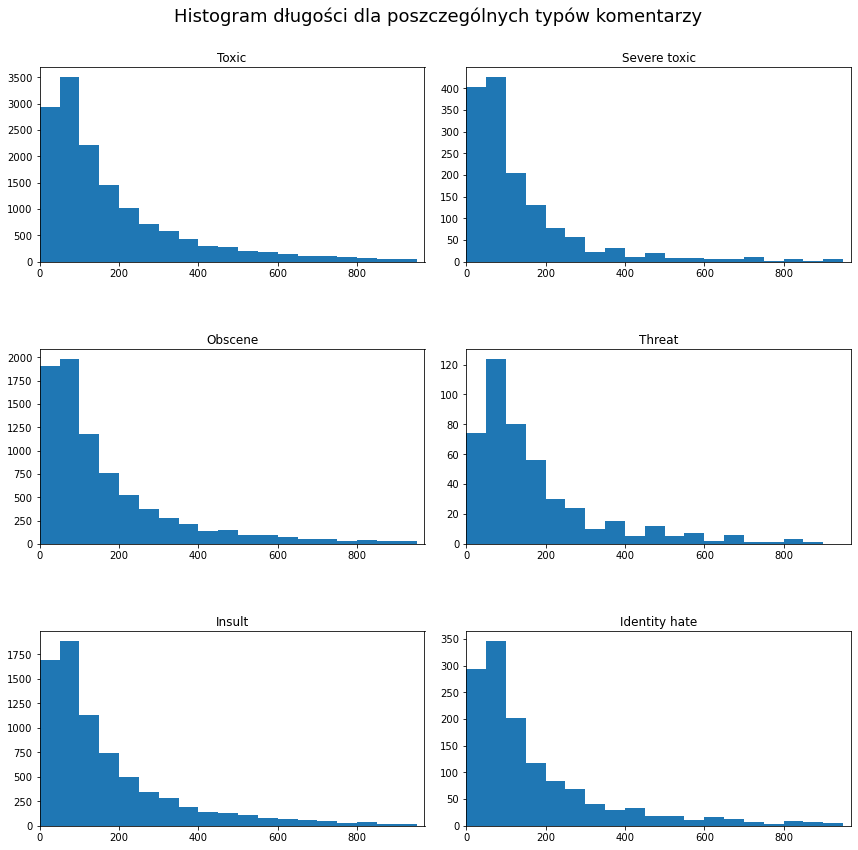

In [143]:
kbins= 10

fig, axs = plt.subplots(3, 2, figsize=(12,12))
fig.tight_layout()

axs[0, 0].hist(train_help[train_help['toxic']==1]['length'], bins=np.arange(0,1000,50))
axs[0, 0].set_title("Toxic", fontsize=12)
axs[0, 0].set_xlim([0, 970])

axs[0, 1].hist(train_help[train_help['severe_toxic']==1]['length'], bins=np.arange(0,1000,50))
axs[0, 1].set_title("Severe toxic", fontsize=12)
axs[0, 1].set_xlim([0, 970])

axs[1, 0].hist(train_help[train_help['obscene']==1]['length'], bins=np.arange(0,1000,50))
axs[1, 0].set_title("Obscene", fontsize=12)
axs[1, 0].set_xlim([0, 970])

axs[1, 1].hist(train_help[train_help['threat']==1]['length'], bins=np.arange(0,1000,50))
axs[1, 1].set_title("Threat", fontsize=12)
axs[1, 1].set_xlim([0, 970])

axs[2, 0].hist(train_help[train_help['insult']==1]['length'], bins=np.arange(0,1000,50))
axs[2, 0].set_title("Insult", fontsize=12)
axs[2, 0].set_xlim([0, 970])

axs[2, 1].hist(train_help[train_help['identity_hate']==1]['length'], bins=np.arange(0,1000,50))
axs[2, 1].set_title('Identity hate', fontsize=12)
axs[2, 1].set_xlim([0, 970])

fig.suptitle("Histogram długości dla poszczególnych typów komentarzy", fontsize=18)
fig.subplots_adjust(top=0.91, hspace=0.45)

Widzimy, że zdecydowanie najwięcej komentarzy ma długość mniejszą niż 100 znaków.

## Zależność między poszczególnymi tagami

### Współczynnik V Cramera

Ze względu na to, że zmienne określające typ komentarza to zmienne binarne, nie możemy użyć standardowego współczynnika korelacji Pearsona.
Wyznaczymy więc współczynnik **V Cramera**. Określa on poziom zależności między dwiema zmiennymi nominalnymi.

Wzór: $$\sqrt{\frac{\chi^2}{n\cdot min(c-1,r-1)}}$$
gdzie:
 * $\chi^2$ - wynik testu zgodności chi-kwadrat
 * $n$ - łączna liczba obserwacji
 * $c$ – liczba kolumn w tabeli kontyngencji,
 * $r$ – liczba wierszy w tabeli kontyngencji

In [144]:
corr_matrix = np.ones(shape=(6,6))
a = 0
for i in train.columns[2:]:
    b = 0
    for j in train.columns[2:]:
        confusion_matrix = pd.crosstab(train[i], train[j])
        
        chi2 = stats.chi2_contingency(confusion_matrix, correction=False)[0]
        n = np.sum(confusion_matrix.values)
        minDim = min(confusion_matrix.shape)-1
        cram_V = np.round(np.sqrt((chi2/n) / minDim), 4)

        corr_matrix[a,b] = cram_V
        corr_matrix[b,a] = cram_V
        b += 1
    a += 1

In [145]:
train_cram_cor = pd.DataFrame(corr_matrix, index = train.columns[2:], columns = train.columns[2:])

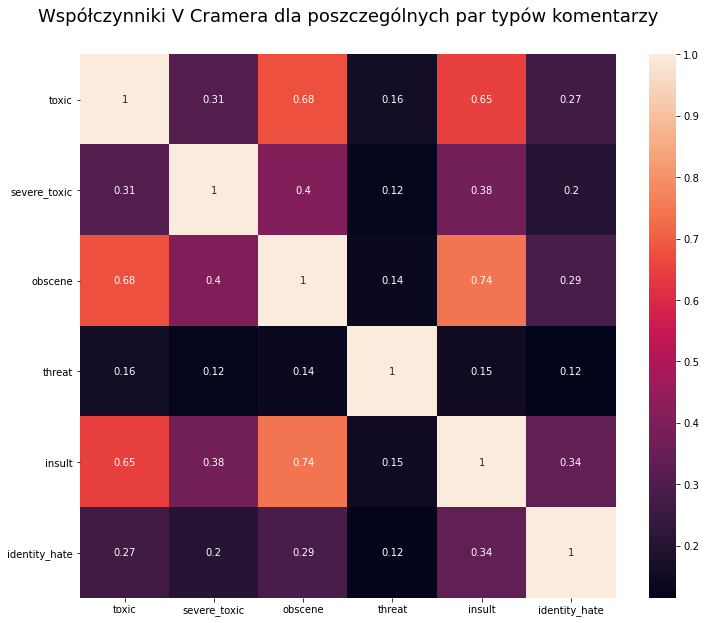

In [147]:
plt.figure(figsize=(12,10))
sns.heatmap(train_cram_cor,
            xticklabels=train_cram_cor.columns.values,
            yticklabels=train_cram_cor.columns.values, annot=True)
plt.yticks(rotation=0)
plt.title("Współczynniki V Cramera dla poszczególnych par typów komentarzy", fontsize=18, y=1.05)
plt.show()

Możemy zauważyć, że komentarze typu *threat* występują niezależnie od innych typów. Z kolei najwyższy poziom zależności wykazują typy:

* *toxic* i *obscene*
* *toxic* i *insult*
* *obscene* i *insult*

## Wizualizacja danych na podstawie WordClouds

W celu zwizualizowania najczęściej występujących słów w komentarzach należących do poszczególnych kategorii zastosujemy chmury słów.

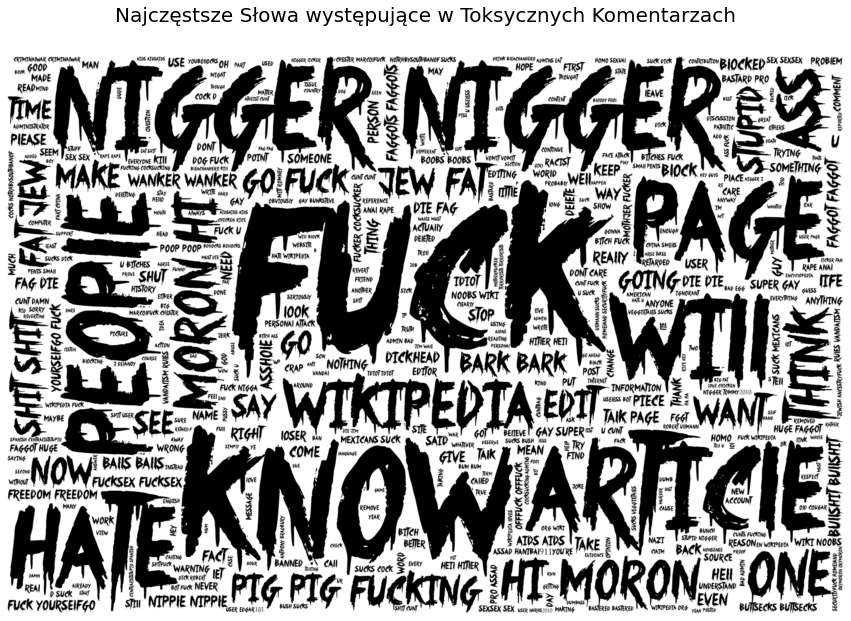

In [148]:
# Najczęstsze występujące słowa na podstawie WordClouds
text = " ".join(comment for comment in train[np.sum(train_values[:,2:], axis=1)>0].comment_text)
# Create and generate a word cloud image:
wordcloud = WordCloud(background_color="white", font_path = 'Something Strange.ttf', width = 3000, height = 2000,
           max_words=500, color_func=lambda *args, **kwargs: "black").generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear') #argument interpolation odpowiada za bardziej gładki obraz*
#*https://www.datacamp.com/community/tutorials/wordcloud-python
plt.axis("off")
plt.title("Najczęstsze Słowa występujące w Toksycznych Komentarzach", fontsize=20, y=1.05)
fig = plt.gcf()
fig.set_size_inches(15, 13)
plt.show()

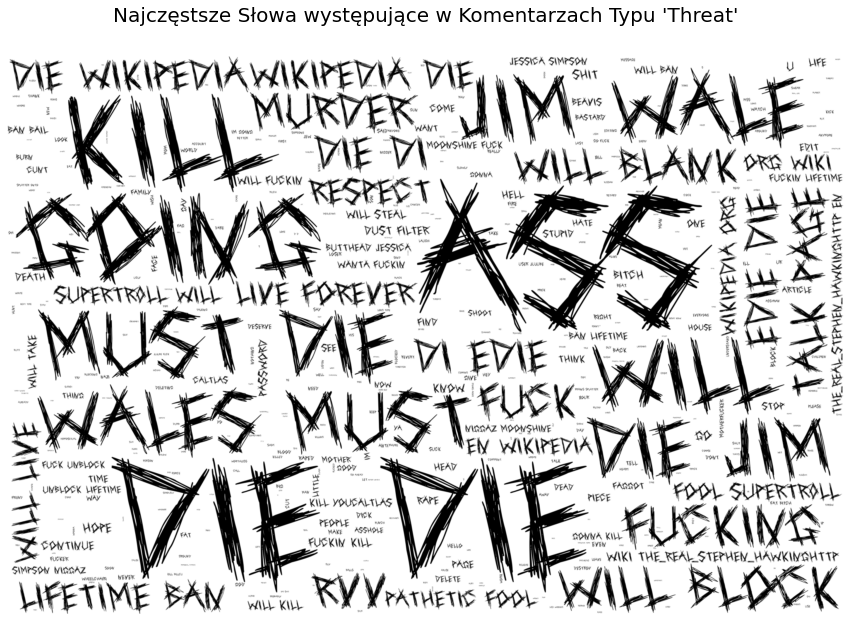

In [149]:
# dla threat
text = " ".join(comment for comment in train[train['threat']==1].comment_text)

wordcloud = WordCloud(background_color="white", font_path = 'HelpMe.ttf', width = 3000, height = 2000,
           max_words=500, color_func=lambda *args, **kwargs: "black").generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Najczęstsze Słowa występujące w Komentarzach Typu 'Threat'", fontsize=20, y=1.05)
fig = plt.gcf()
fig.set_size_inches(15, 13)
plt.show()

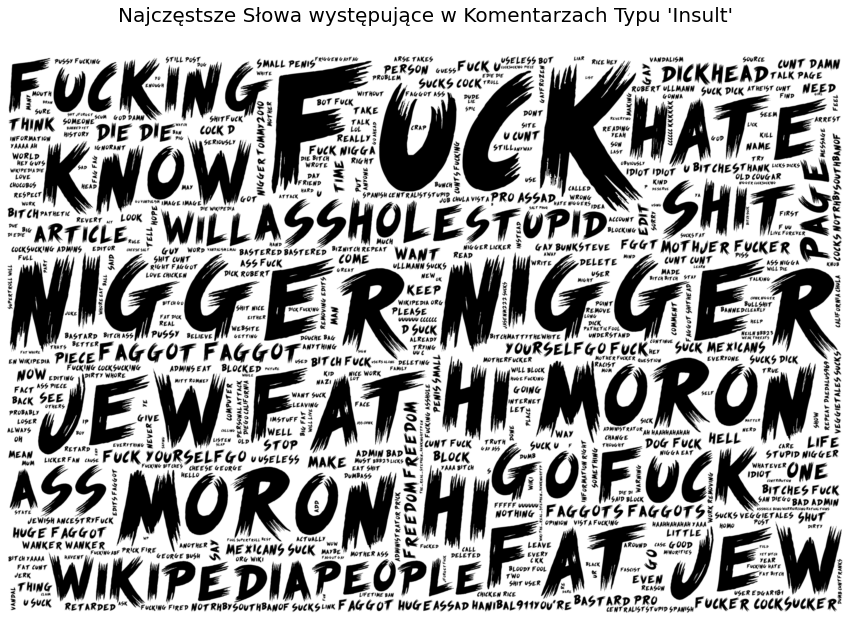

In [150]:
# dla insult
text = " ".join(comment for comment in train[train['insult']==1].comment_text)

wordcloud = WordCloud(background_color="white", font_path = 'Scream Again.ttf', width = 3000, height = 2000,
           max_words=500, color_func=lambda *args, **kwargs: "black").generate(text)


plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Najczęstsze Słowa występujące w Komentarzach Typu 'Insult'", fontsize=20, y=1.05)
fig = plt.gcf()
fig.set_size_inches(15, 13)
plt.show()

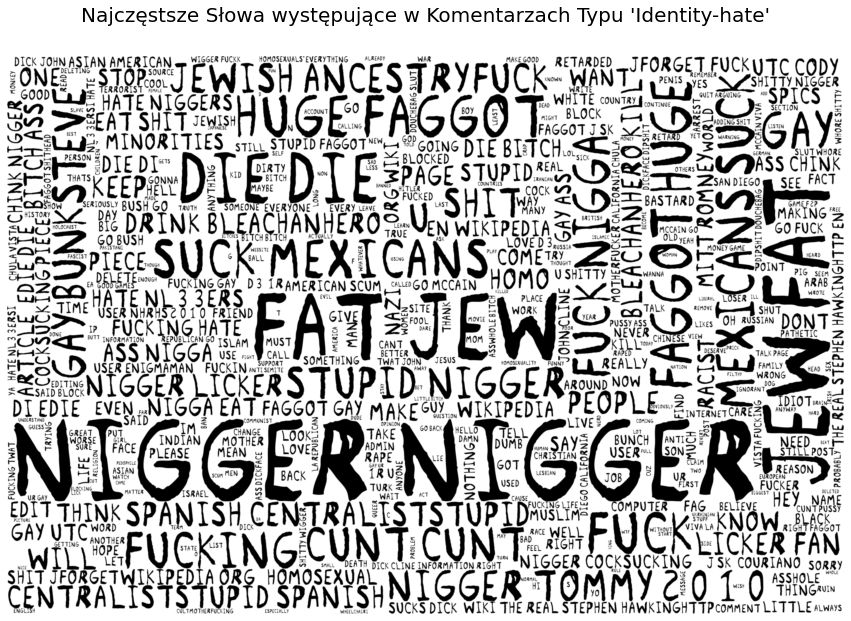

In [151]:
# dla identity_hate
text = " ".join(comment for comment in train[train['identity_hate']==1].comment_text)

wordcloud = WordCloud(background_color="white", font_path = 'Remnant-Regular.ttf', width = 3000, height = 2000,
           max_words=500, color_func=lambda *args, **kwargs: "black").generate(text)


plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Najczęstsze Słowa występujące w Komentarzach Typu 'Identity-hate'", fontsize=20, y=1.05)
fig = plt.gcf()
fig.set_size_inches(15, 13)
plt.show()

Analizując powyższe chumry słów można zauważyć, że bardzo często występują słowa nacechowane negatywnie lub kojarzące się ze słowami obraźliwymi. Jednakże często pojawiają się również zaimki lub podstawowe czasowniki, a także niektóre słowa pojawiają się w różnych formach. Może to utrudniać interpretację wykresów. W kolejnych sekcjach tego raportu zajmiemy się przetworzeniem analizowanych zmiennych tekstowych.

## Zbiór testowy

Zbiór testowy zawarty jest w dwóch plikach:
* *test.csv* - zawiera id komentarzy oraz ich tekst
* *test_labels.csv* - zawiera id kometarzy oraz kolumny z wartościami binarnymi przydzielające komentarz do danej kategorii.

In [198]:
test_raw = pd.read_csv('test.csv') #wczytanie zbioru danych
print(test_raw.head())
print("\n Liczba obserwacji w zbiorze testowym:", test_raw.shape[0])

                 id                                       comment_text
0  00001cee341fdb12  Yo bitch Ja Rule is more succesful then you'll...
1  0000247867823ef7  == From RfC == \n\n The title is fine as it is...
2  00013b17ad220c46  " \n\n == Sources == \n\n * Zawe Ashton on Lap...
3  00017563c3f7919a  :If you have a look back at the source, the in...
4  00017695ad8997eb          I don't anonymously edit articles at all.

 Liczba obserwacji w zbiorze testowym: 153164


In [192]:
test_labels = pd.read_csv('test_labels.csv') #wczytanie zbioru danych
test_labels.head()

id  toxic  severe_toxic  obscene  threat  insult  \
0  00001cee341fdb12     -1            -1       -1      -1      -1   
1  0000247867823ef7     -1            -1       -1      -1      -1   
2  00013b17ad220c46     -1            -1       -1      -1      -1   
3  00017563c3f7919a     -1            -1       -1      -1      -1   
4  00017695ad8997eb     -1            -1       -1      -1      -1   

   identity_hate  
0             -1  
1             -1  
2             -1  
3             -1  
4             -1

Zbiory treningowy i testowy są podobnych rozmiarów, jednak możemy zauważyć, że w zbiorze testowym są obserwacje, które dla zmiennych binarnych przyjmują wartości -1. Oznacza to, że obserwacje te nie są brane pod uwagę przy predykcji i ocenie modelu. W celach przejrzystości i dalszych analiz usuniemy takie rekordy.

In [200]:
test = test_raw.merge(test_labels, left_on = 'id', right_on='id')

X_test_raw = test['comment_text'] 
y_test_raw = test.iloc[:,2:]

y_test = y_test_raw[(y_test_raw['toxic']!=-1) & (y_test_raw['severe_toxic']!=-1) &
                   (y_test_raw['obscene']!=-1) & (y_test_raw['threat']!=-1) &
                   (y_test_raw['insult']!=-1) & (y_test_raw['identity_hate']!=-1)].reset_index().drop(axis = 1, labels = "index")

X_test = X_test_raw[(y_test_raw['toxic']!=-1) & (y_test_raw['severe_toxic']!=-1) &
                   (y_test_raw['obscene']!=-1) & (y_test_raw['threat']!=-1) &
                   (y_test_raw['insult']!=-1) & (y_test_raw['identity_hate']!=-1)]

In [201]:
print("Liczba obserwacji w zbiorze testowym po usunięciu zbędnych obserwacji: ", y_test.shape[0])

Liczba obserwacji w zbiorze testowym po usunięciu zbędnych obserwacji:  63978


Liczba obserwacji w zbiorze testowym zdecydowanie się zmniejszyła, dzięki temu ich stosunek do obserwacji ze zbioru treningowego jest korzystniejszy.

# Przetwarzanie danych tekstowych

W tej sekcji skupimy się głównie na przygotowaniu danych tekstowych - ich wektoryzacji, ekstrakcji cechy i czyszczeniu. ID komentarzy nie będą nam potrzebne w dalszej klasyfikacji, więc usuniemy tą zmienną ze zbioru treningowego. Podzielimy też ten zbiór na zmienne objaśniające (komentarze) i objaśniane (zmienne klasyfikujące komentarz do poszczególnych kategorii).

In [153]:
train.drop(axis = 1, labels = "id", inplace = True)

In [155]:
#podział na zmienne objaśniające i objaśniane
X_train = train.comment_text
y_train = train.drop(axis = 1, labels = "comment_text")

In [8]:
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud
from nltk.stem.snowball import SnowballStemmer
from sklearn.model_selection import train_test_split
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.metrics import roc_auc_score , accuracy_score , confusion_matrix , f1_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

## Normalizacja
Normalizacja tekstu polega na takim jego przetworzeniu, aby miał spójną formę, która ułatwi dalszą interpretację tekstu (przykłady: zmiana liter na małe bądź wielkie, rozwinięcie skrótów, normalizacja skrótowców, konwersja wyrażeń numerycznych i wyrażeń słowno-numerycznych do postaci słownej, normalizacja znaków specjalnych – takich jak symbol akapitu czy znak zastrzeżenia prawa autorskiego, usunięcie lub zmiana znaków interpunkcyjnych itd.).


In [10]:
def  clean_text(text):
    text =  text.lower()
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"\r", "", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"that's", "that is", text)
    text = re.sub(r"what's", "that is", text)
    text = re.sub(r"where's", "where is", text)
    text = re.sub(r"how's", "how is", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can't", "cannot", text)
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"n'", "ng", text)
    text = re.sub(r"'bout", "about", text)
    text = re.sub(r"'til", "until", text)
    text = re.sub(r"[-()\"#/@;:<>{}`+=~|.!?,]", "", text)
    text = text.translate(str.maketrans('', '', string.punctuation)) 
    text = re.sub("(\\W)"," ",text) 
    text = re.sub('\S*\d\S*\s*','', text)
    
    return text

Poniżej pokażemy działanie normalizacji na przykładnie jednego z komentarzy.

Tekst przed normalizacją:

In [158]:
print(X_train[0])

Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27


Tekst po normalizacji:

In [160]:
X_train = X_train.apply(clean_text)
print(X_train[0])

explanation why the edits made under my username hardcore metallica fan were reverted they were not vandalisms just closure on some gas after i voted at new york dolls fac and please do not remove the template from the talk page since i am retired 


In [55]:
X_test = X_test.apply(clean_text)

## Stop words
Są to najczęściej występujące słowa języka, które na ogół nie niosą ze sobą żadnych istotnych treści. Są zatem zazwyczaj usuwane w celu optymalizacji modelu.

W celu wykrycia i usunięcia wspomnianych słów skorzystamy z biblioteki *spaCy*, a konkretnie z anglojęzycznego pakietu *STOP_WORDS*.

In [13]:
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS

#nltk.download('stopwords')
nlp = English()
# "nlp" Obiekt służy do tworzenia dokumentów z adnotacjami lingwistycznymi

def stop_words_remove(text):
    nlp_doc = nlp(text)

    #tworzymi listę tokenów z przetwarzanego tekstu
    tokens = []
    for token in nlp_doc:
        tokens.append(token.text)

    # usuwamy 'stop words' i tworzymy nową listę tokenów
    filtered_tokens =[] 

    for word in tokens:
        word_id = nlp.vocab[word]
        if word_id.is_stop == False:
            filtered_tokens.append(word)
    
    filtered_comment = ' '.join(filtered_tokens) 
    
    return filtered_comment

**Przykład działania** (tekst wcześniej został znormalizowany)

Przykład komentarza przed przetworzeniem:

In [14]:
X_train[8]

'sorry if the word nonsense was offensive to you anyway i am not intending to write anything in the articlewow they would jump on me for vandalism i am merely requesting that it be more encyclopedic so one can use it for school as a reference i have been to the selective breeding page but it is almost a stub it points to animal breeding which is a short messy article that gives you no info there must be someone around with expertise in eugenics '

Ten sam komentarz po przetworzeniu:

In [15]:
stop_words_remove(X_train[8])

'sorry word nonsense offensive intending write articlewow jump vandalism merely requesting encyclopedic use school reference selective breeding page stub points animal breeding short messy article gives info expertise eugenics'

In [179]:
X_train_stop = X_train.apply(stop_words_remove)

In [56]:
X_test_stop = X_test.apply(stop_words_remove)

## Stemming 
Stemming jest procesem usunięcia końcówki fleksyjnej ze słowa, w  czego efekcie pozostaje tylko temat wyrazu. 


In [17]:
sn = SnowballStemmer(language='english')


def stemmer(text):
    words =  text.split()
    train = [sn.stem(word) for word in words if not word in set(stopwords.words('english'))]
    return ' '.join(train)

Przykład komentarza przed zastosowanium stemmingu (już po usunięciu wyrazów typu *stop words*):

In [181]:
X_train_stop[3]

'  real suggestions improvement   wondered section statistics later subsection types accidents   think references need tidying exact format ie date format etc later   preferences formatting style references want let know   appears backlog articles review guess delay reviewer turns listed relevant form eg wikipediagoodarticlenominationstransport  '

Ten sam komentarz po przetworzeniu:

In [182]:
stemmer(X_train_stop[3])

'real suggest improv wonder section statist later subsect type accid think refer need tidi exact format ie date format etc later prefer format style refer want let know appear backlog articl review guess delay review turn list relev form eg wikipediagoodarticlenominationstransport'

In [59]:
X_test_stem = X_test_stop.apply(stemmer)

In [18]:
X_train_stem = X_train_stop.apply(stemmer)

## Lematyzacja

Lematyzacja to sprowadzenie słowa do jego podstawowej postaci. Na przykład w przypadku czasownika to najczęściej będzie bezokolicznik, w przypadku rzeczownika sprowadzamy do mianownika liczby pojedynczej.

In [21]:
import spacy


#budujemy model
#NER - Named Entity Recognition - wyłączamy
#'parser' daje informacje składniowe - póki co ich nie potrzebujemy. 
# https://spacy.io/usage/linguistic-features#disabling

# Wyłączenie parsera sprawi, że SpaCy będzie ładował się i działał znacznie szybciej
# https://spacy.io/usage/linguistic-features#named-entities
load_model = spacy.load('en_core_web_sm', disable = ['parser','ner'])

def lemmatization(text):
    text_model = load_model(text)
    result = " ".join([token.lemma_ for token in text_model])
    return result

**Przykład działania**

Obserwacja ze zbioru przed zastosowaniem lematyzacji:

In [183]:
X_train_stop[3]

'  real suggestions improvement   wondered section statistics later subsection types accidents   think references need tidying exact format ie date format etc later   preferences formatting style references want let know   appears backlog articles review guess delay reviewer turns listed relevant form eg wikipediagoodarticlenominationstransport  '

Ten sama obserwacja po zastosowaniu lematyzacji:

In [185]:
lemmatization(X_train_stop[3])

'   real suggestion improvement    wonder section statistic later subsection type accident    think reference need tidy exact format ie date format etc later    preference format style reference want let know    appear backlog article review guess delay reviewer turn list relevant form eg wikipediagoodarticlenominationstransport  '

In [22]:
X_train_lem = X_train_stop.apply(lemmatization)

In [58]:
X_test_lem = X_test_stop.apply(lemmatization)

## Porównanie zmiennych przed i po przetworzeniu

Po raz kolejny używając wykresów typu *Wordclouds* porównamy występujące słowa przed i po przetworzeniu komentarzy w zbiorze treningowym. 

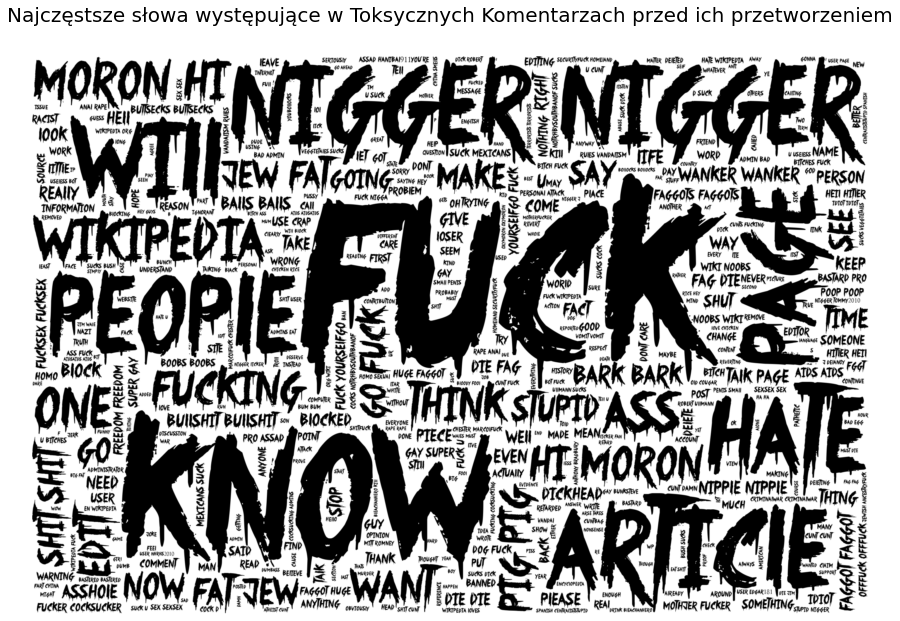

In [203]:
# Najczęstsze występujące słowa na podstawie WordClouds
text = " ".join(comment for comment in train[np.sum(train_values[:,2:], axis=1)>0].comment_text)
# Create and generate a word cloud image:
wordcloud = WordCloud(background_color="white", font_path = 'Something Strange.ttf', width = 3000, height = 2000,
           max_words=500, color_func=lambda *args, **kwargs: "black").generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear') #argument interpolation odpowiada za bardziej gładki obraz*
#*https://www.datacamp.com/community/tutorials/wordcloud-python
plt.axis("off")
plt.title("Najczęstsze słowa występujące w Toksycznych Komentarzach przed ich przetworzeniem", fontsize=20, y=1.05)
fig = plt.gcf()
fig.set_size_inches(15, 13)
plt.show()

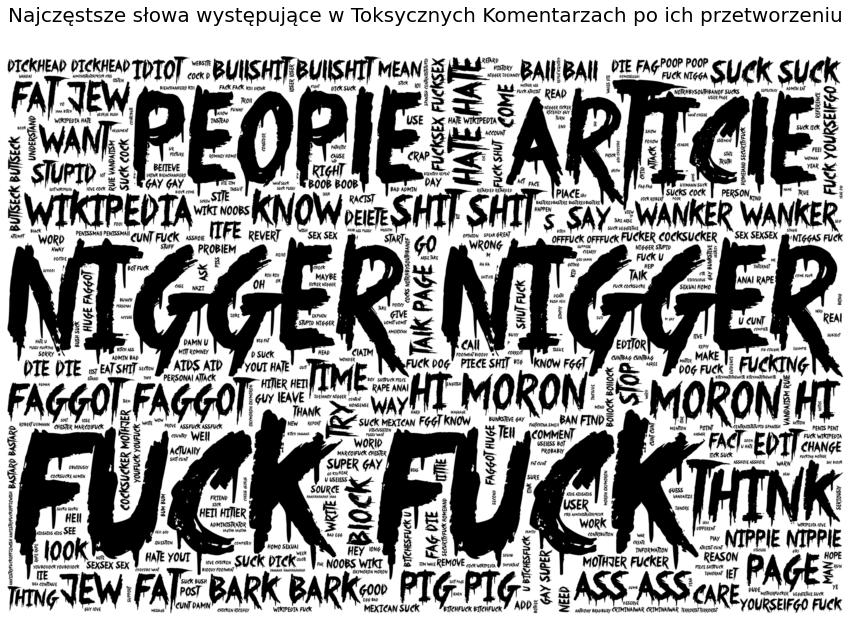

In [207]:
# Najczęstsze występujące słowa na podstawie WordClouds
text = " ".join(comment for comment in X_train_lem[np.sum(train_values[:,2:], axis=1)>0])
# Create and generate a word cloud image:
wordcloud = WordCloud(background_color="white", font_path = 'Something Strange.ttf', width = 3000, height = 2000,
           max_words=500, color_func=lambda *args, **kwargs: "black").generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear') #argument interpolation odpowiada za bardziej gładki obraz*
#*https://www.datacamp.com/community/tutorials/wordcloud-python
plt.axis("off")
plt.title("Najczęstsze słowa występujące w Toksycznych Komentarzach po ich przetworzeniu", fontsize=20, y=1.05)
fig = plt.gcf()
fig.set_size_inches(15, 13)
plt.show()

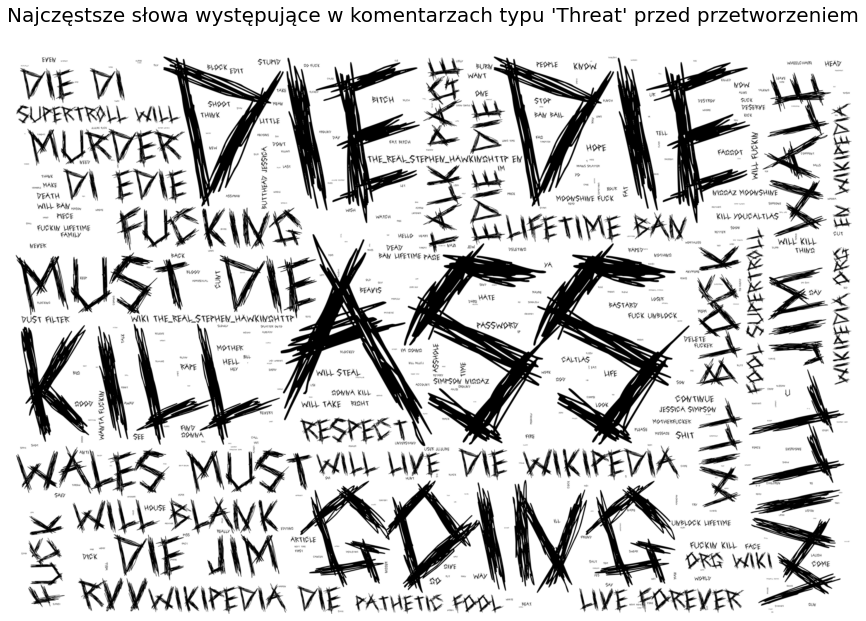

In [210]:
# dla threat
text = " ".join(comment for comment in train[train['threat']==1].comment_text)

wordcloud = WordCloud(background_color="white", font_path = 'HelpMe.ttf', width = 3000, height = 2000,
           max_words=500, color_func=lambda *args, **kwargs: "black").generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Najczęstsze słowa występujące w komentarzach typu 'Threat' przed przetworzeniem", fontsize=20, y=1.05)
fig = plt.gcf()
fig.set_size_inches(15, 13)
plt.show()

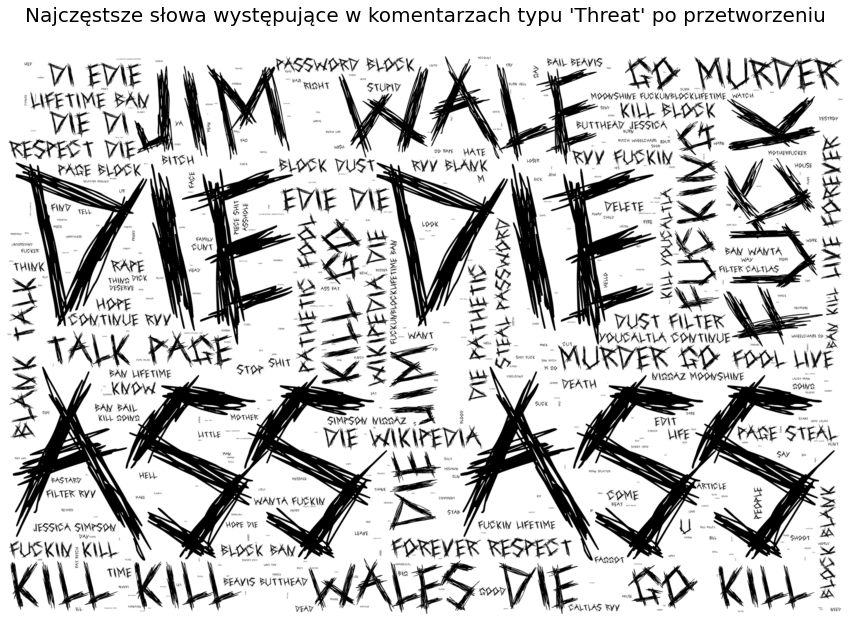

In [211]:
# dla threat
text = " ".join(comment for comment in X_train_lem[train['threat']==1])

wordcloud = WordCloud(background_color="white", font_path = 'HelpMe.ttf', width = 3000, height = 2000,
           max_words=500, color_func=lambda *args, **kwargs: "black").generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Najczęstsze słowa występujące w komentarzach typu 'Threat' po przetworzeniu", fontsize=20, y=1.05)
fig = plt.gcf()
fig.set_size_inches(15, 13)
plt.show()

## Wektoryzacja

Na początku przedstawimy kilka podstawowych pojęć związanych z przetwarzaniem języka naturalnego.
### „Bag of words” 
Aby algorytm mógł sobie poradzić z tekstem, musimy najpierw podzielić ten tekst na mniejsze fragmenty. Stworzenie tzw. "worka słów" jest jednym ze sposób na uzyskanie takiego podziału. Każde słowo użyte w tekście zostaje wyodrębnione i wrzucone do multizbioru. Dla przykładu, jeśli mamy dwa zdania: „Marcin ma kota.” oraz „Patryk ma psa.”, to w worku słów znajdzie się pięć słów: Marcin, ma, kota, Patryk, psa. Ich kolejność nie będzie odgrywała roli.


### N_gram
W naszym worku mogą się znaleźć nie tylko pojedyńcze słowa, ale pewne sekwencje słów. N-gram jest ciągiem elementów z danej próbki tekstu bądź mowy. Zazwyczaj jednym elementem jest pojedyncze słowo (ale w określonych przypadkach mogą też być to fonemy, litery lub sylaby).

### Wektoryzacja - pierwszy sposób

Z "bag of words" blisko związanym terminem jest wektoryzacjia. Najprostszym wektoryzatorem jest CountVectorizer. Zlicza on liczbę wystąpień każdego wyrazu (lub n_gramu) w tekście i przedstawia za pomocą wektora składającego się z liczb naturalnych. Każda liczba informuje, ile razy dany element wystąpił w analizowanym tekście.

Przykładem innego wektoryzatora, który rozpatrywaliśmy w naszym projekcie, jest wektoryzator TF-IDF. Opiera się on na metodzie obliczania wagi słów w oparciu o liczbę ich wystąpień w całym zbiorze jak i w pojedyńczych dokumentach.

$$\text{Dla termu }t_i\text{ w dokumencie }d_j\text{ mamy:}$$

$$(tf-idf)_{i,j} = (tf)_{i,j} \times (idf)_{i}$$
gdzie:

$(tf)_{i,j}-$ term frequency, liczba wystąpień termu $t_i$ w dokumencie $d_j$ podzielona przez liczbę wszystkich termów w $d_j.$

$(idf)_i-$ inverse document frequency, $(idf)_i = ln\left( \dfrac{|D|}{|\{j\ : f_i \in d_j\}|} \right)$ - gdzie $D$ to zbiór wszystkich dokumentów.


In [26]:
word_vectorizer = TfidfVectorizer(
    strip_accents='unicode', #normalizacja tekstu, usuwanie akcentów itp. unicode jest wolniejsza, ale radzi sobie z dowolnymi znakami   
    token_pattern=r'\w{1,}',  #co zaliczamy jako token - tutaj są to obiekty typu r'\w' czyli o kategorii alfabetonumerycznej, o długości 1 lub większej   
    ngram_range=(1, 3),      #liczba możliwych n-gramów - tutaj dopuszczamy mono-, bi-, i tri-gramy  
    stop_words='english', #jaka kategoria dla stopwords, domyślnie jest None, dostępna jest opcja 'english' lub inna własna lista
    sublinear_tf=True) #zamiast term frequency (tf) oddaje 1+ln(tf)


In [27]:
word_vectorizer_basic = word_vectorizer
word_vectorizer_basic.fit(X_train)
X_train_transformed = word_vectorizer_basic.transform(X_train)

In [28]:
word_vectorizer_stop = word_vectorizer
word_vectorizer_stop.fit(X_train_stop)
X_train_stop_transformed = word_vectorizer_stop.transform(X_train_stop)

In [29]:
word_vectorizer_stem = word_vectorizer
word_vectorizer_stem.fit(X_train_stem)
X_train_stem_transformed = word_vectorizer_stem.transform(X_train_stem)

In [30]:
word_vectorizer_lem = word_vectorizer
word_vectorizer_lem.fit(X_train_lem)
X_train_lem_transformed = word_vectorizer_lem.transform(X_train_lem)

Poniżej przedstawiamy przykład jednej obserwacji przed i po wektoryzacji. 

Przed wektoryzacją:

In [190]:
X_train[1]

'daww he matches this background colour i am seemingly stuck with thanks  talk january utc'

Po wektoryzacji:

In [31]:
print(X_train_transformed[1])

  (0, 6048811)	0.08034046234044398
  (0, 5657981)	0.22482565382989295
  (0, 5657940)	0.1279446858802597
  (0, 5650041)	0.0680924444125307
  (0, 5554984)	0.2151597556837971
  (0, 5554982)	0.19859404078686696
  (0, 5552001)	0.055480697237542426
  (0, 5417567)	0.232497908811692
  (0, 5417566)	0.232497908811692
  (0, 5417204)	0.136113412161602
  (0, 5030487)	0.232497908811692
  (0, 5030486)	0.232497908811692
  (0, 5030249)	0.14934566279844375
  (0, 3424079)	0.232497908811692
  (0, 3424078)	0.232497908811692
  (0, 3424051)	0.13724967787894
  (0, 2892413)	0.13885693462322307
  (0, 2891410)	0.11528669465092176
  (0, 1380502)	0.232497908811692
  (0, 1380501)	0.232497908811692
  (0, 1380500)	0.232497908811692
  (0, 1045380)	0.232497908811692
  (0, 1045379)	0.232497908811692
  (0, 1045140)	0.15131336749531227
  (0, 508480)	0.232497908811692
  (0, 508479)	0.232497908811692
  (0, 508274)	0.12379787673557346


źródła: https://www.statystyczny.pl/klasyfikacja-tekstu-text-classification/

Warto zaznaczyć, że dla zbioru testowego będziemy jedynie stosować transformację zmiennych tekstowych na bazie wektoryzatora nauczonego na zbiorze treningowym.

In [60]:
word_vectorizer_basic.fit(X_train)
X_test_transformed = word_vectorizer_basic.transform(X_test)

word_vectorizer_stop.fit(X_train_stop)
X_test_stop_transformed = word_vectorizer_stop.transform(X_test_stop)

word_vectorizer_lem.fit(X_train_lem)
X_test_lem_transformed = word_vectorizer_lem.transform(X_test_lem)

word_vectorizer_stem.fit(X_train_stem)
X_test_stem_transformed = word_vectorizer_stem.transform(X_test_stem)

### Inny sposób wektoryzacji - CountVectorizer

*CountVectorizer* zlicza ilość wystąpień danych tokenów w zmiennej tekstowej i tworzy macierz (zazwyczaj jest to macierz rzadka), której element przedstawia liczbę wystąpień danego tokenu.

Implementacja tego algorytmu tworzy reprezentację *sparse* przy użyciu *scipy.sparse.csr_matrix*, która umożliwia efektywne działanie na macierzy zarówno pod względem obliczniowym, jak i pamięciowym.

In [81]:
from sklearn.feature_extraction.text import CountVectorizer

vect_count = CountVectorizer()

In [82]:
X_train_lem_count = vect_count.fit_transform(X_train_lem)
X_test_lem_count = vect_count.transform(X_test_lem)

# Modele - eksperymenty & implementacja

In [36]:
#pakiety do budowania modelu
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import GridSearchCV

## Aspekty teoretyczne

### One vs Rest Classifier
Strategia one-vs-rest również znana jako one-vs-all polega na dopasowaniu oddzielnych modeli do każdej klasy - tzn. budujemy n modeli regresji logistycznej dla problemu klasyfikacji binarnej z klasami "klasa n" oraz "inne klasy"

### Regresja logistyczna

W naszym modelu używamy solvera *saga* w LogisticRegression(). Solver ten o wiele szybciej radzi sobie z dużymi zbiorami danych oraz z problemami multiclass. Parametr *C*, który dobieramy za pomocą GridSearch(), jest odwrotnością siły regularyzacji l2 w modelu.


Poniżej tworzymy trzy modele na podstawie zbiorów po różnych etapach obróki wstępnej. 

### Grid Search
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

https://scikit-learn.org/stable/modules/grid_search.html


Zamiast ręcznie wpisywać wartości poszczególnych parametrów, poszukamy najlepszych z nich za pomocą *GridSearch*.

In [40]:
parameters = {'estimator__C': list}
multi_logistic = OneVsRestClassifier(LogisticRegression(solver = 'saga', penalty = 'l2'))
clf = GridSearchCV(multi_logistic, parameters)

In [41]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import multilabel_confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score

## Budowa modeli

Modele budujemy ucząc je na zbiorach treningowych będących na różnych etapach przetworzenia (i zwektoryzowanych za pomocą *TfidfVectorizer*). Następnie dokonujemy predykcji na zbiorze testowym, który został przetworzony w ten sam sposób co treningowy.

In [62]:
list = np.arange(1,5, step = 1)

In [64]:
clf_basic = GridSearchCV(multi_logistic, parameters)
clf_basic.fit(X_train_transformed, y_train)
clf_basic.get_params()
acc_basic = accuracy_score(clf_basic.predict(X_test_transformed), y_test)

In [212]:
basic_pred = clf_basic.predict(X_test_transformed)

In [71]:
clf_stop = GridSearchCV(multi_logistic, parameters)
clf_stop.fit(X_train_stop_transformed, y_train)
clf_stop.get_params()
acc_stop = accuracy_score(clf_stop.predict(X_test_stop_transformed), y_test)

In [72]:
stop_pred = clf_stop.predict(X_test_stop_transformed)

In [74]:
clf_lem = GridSearchCV(multi_logistic, parameters)
clf_lem.fit(X_train_lem_transformed, y_train)
clf_lem.get_params()
acc_lem = accuracy_score(clf_lem.predict(X_test_lem_transformed), y_test)

In [75]:
lem_pred = clf_lem.predict(X_test_lem_transformed)

In [77]:
clf_stem = GridSearchCV(multi_logistic, parameters)
clf_stem.fit(X_train_stem_transformed, y_train)
clf_stem.get_params()
acc_stem = accuracy_score(clf_stem.predict(X_test_stem_transformed), y_test)

Przykładowe parametry wybrane w wyniku zastosowania *GridSearchCV*:

In [215]:
clf_stem.get_params()

{'cv': None,
 'error_score': nan,
 'estimator__estimator__C': 1.0,
 'estimator__estimator__class_weight': None,
 'estimator__estimator__dual': False,
 'estimator__estimator__fit_intercept': True,
 'estimator__estimator__intercept_scaling': 1,
 'estimator__estimator__l1_ratio': None,
 'estimator__estimator__max_iter': 100,
 'estimator__estimator__multi_class': 'auto',
 'estimator__estimator__n_jobs': None,
 'estimator__estimator__penalty': 'l2',
 'estimator__estimator__random_state': None,
 'estimator__estimator__solver': 'saga',
 'estimator__estimator__tol': 0.0001,
 'estimator__estimator__verbose': 0,
 'estimator__estimator__warm_start': False,
 'estimator__estimator': LogisticRegression(solver='saga'),
 'estimator__n_jobs': None,
 'estimator': OneVsRestClassifier(estimator=LogisticRegression(solver='saga')),
 'iid': 'deprecated',
 'n_jobs': None,
 'param_grid': {'estimator__C': array([1, 2, 3, 4])},
 'pre_dispatch': '2*n_jobs',
 'refit': True,
 'return_train_score': False,
 'scoring'

In [78]:
stem_pred = clf_stem.predict(X_test_stem_transformed)

Budowa modelu dla danych po lematyzacji zwektoryzowanych za pomocą *CountVectorizer*.

In [245]:
clf_lem2 = GridSearchCV(multi_logistic, parameters)
clf_lem2.fit(X_train_lem_count, y_train)
clf_lem2.get_params()
acc_lem2 = accuracy_score(clf_lem2.predict(X_test_lem_count), y_test)

In [85]:
lem2_pred = clf_lem2.predict(X_test_lem_count)

### Ręcznie ustawione wartości parametrów dla zdefiniowanego wcześniej modelu regresji logistycznej

W celu sprawdzenia jakości działania *GridSearchCV* zbudujemy również model dla regresji logistycznej z ręcznie dobranymi parametrami.

In [93]:
log_reg = LogisticRegression(C = 10, penalty='l2', solver = 'liblinear', random_state=73, max_iter=1000)

In [94]:
one_vs_rest = OneVsRestClassifier(log_reg)
one_vs_rest.fit(X_train_lem_count, y_train)

C:\Users\patry\anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


OneVsRestClassifier(estimator=LogisticRegression(C=10, max_iter=1000,
                                                 random_state=73,
                                                 solver='liblinear'))

In [95]:
lem3_pred_proba = one_vs_rest.predict_proba(X_test_lem_count)
roc_auc_score_test = roc_auc_score(y_test, lem3_pred_proba,average='weighted')
acc3_lem = accuracy_score(one_vs_rest.predict(X_test_lem_count), y_test)

In [96]:
lem3_pred = one_vs_rest.predict(X_test_lem_count)

### Ważone klasy

Już na wcześniejszych etapach realizacji projektu, zauważyliśmy, że liczność obserwacji należących do jakiejkolwiek klasy oraz nienależących do żadnej z klas, jest niezbalansowana. Podjęliśmy więc próbę zbudowania modelu regresji uwzględniającego wagi dla omawianych klas. Dzięki takiemu działaniu model powinien zwracać większą uwagę na obserwacje przynajeżące do którejś z kategorii.

In [99]:
weights = {0:1.0, 1:5.0}
logreg_weight = OneVsRestClassifier(LogisticRegression(solver='saga', class_weight=weights))
clf_weight = GridSearchCV(logreg_weight, parameters)

In [243]:
import warnings
warnings.filterwarnings('ignore')

In [246]:
clf_weight.fit(X_train_lem_transformed, y_train)
clf_weight.get_params()
acc_lem_weight = accuracy_score(clf_weight.predict(X_test_lem_transformed), y_test)

In [224]:
weight_pred = clf_weight.predict(X_test_lem_transformed)

In [241]:
print('Liczba obserwacji przydzielonych do poszczególnych kategorii w modelu')
np.sum(clf_weight.predict(X_test_lem_transformed), axis=0) 

Liczba obserwacji przydzielonych do poszczególnych kategorii w modelu


array([11167,  1221,  5966,   485,  5720,  1068])

In [242]:
print('Liczba obserwacji przydzielonych do poszczególnych kategorii w oryginalnym zbiorze')
np.sum(np.array(y_test), axis=0) 

Liczba obserwacji przydzielonych do poszczególnych kategorii w oryginalnym zbiorze


array([6090,  367, 3691,  211, 3427,  712], dtype=int64)

Widzimy, że po dodaniu wag dla klas w regresji logistycznej, model zdecydowanie więcej obserwacji przydzielił do co najmniej jednej z kategorii. 

### Dla wbudowanej wartości *balanced*  

In [247]:
logreg_weight2 = OneVsRestClassifier(LogisticRegression(solver='saga', class_weight='balanced'))
clf_weight2 = GridSearchCV(logreg_weight2, parameters)

clf_weight2.fit(X_train_lem_transformed, y_train)
clf_weight2.get_params()
acc_lem_weight2 = accuracy_score(clf_weight2.predict(X_test_lem_transformed), y_test)

In [225]:
balanced_pred = clf_weight2.predict(X_test_lem_transformed)

In [240]:
print("Liczba obserwacji przydzielonych przez model do danej kategorii:")
np.sum(clf_weight2.predict(X_test_lem_transformed), axis=0)

Liczba obserwacji przydzielonych przez model do danej kategorii:


array([12254,  7140,  7434,  8378,  8415,  7661])

W tym przypadku również dużo więcej obserwacji zostało przydzielone do chociaż jednej kategorii.

# Ewaluacja wyników

In [115]:
from sklearn.metrics import multilabel_confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score

## Dokładność i pole pod krzywą ROC

In [273]:
acc = []
acc.append(acc_basic)
acc.append(acc_stop)
acc.append(acc_lem)
acc.append(acc_stem)
acc.append(acc_lem2)
acc.append(acc3_lem)
acc.append(acc_lem_weight)
acc.append(acc_lem_weight2)

In [274]:
auc = []
auc.append(roc_auc_score(y_test, basic_pred, multi_class='ovr'))
auc.append(roc_auc_score(y_test, stop_pred, multi_class='ovr'))
auc.append(roc_auc_score(y_test, lem_pred, multi_class='ovr'))
auc.append(roc_auc_score(y_test, stem_pred, multi_class='ovr'))
auc.append(roc_auc_score(y_test, lem2_pred, multi_class='ovr'))
auc.append(roc_auc_score(y_test, lem3_pred, multi_class='ovr'))
auc.append(roc_auc_score(y_test, weight_pred, multi_class='ovr'))
auc.append(roc_auc_score(y_test, balanced_pred, multi_class='ovr'))


In [312]:
indices = ['Original Dataset', 'Stop Words', 'Lematization', 'Stemming', 'CountVectiorizer', 'Ręcznie ustalone parametry',
          'Ręcznie ustalone wagi', 'Wagi - parametr "balanced"']

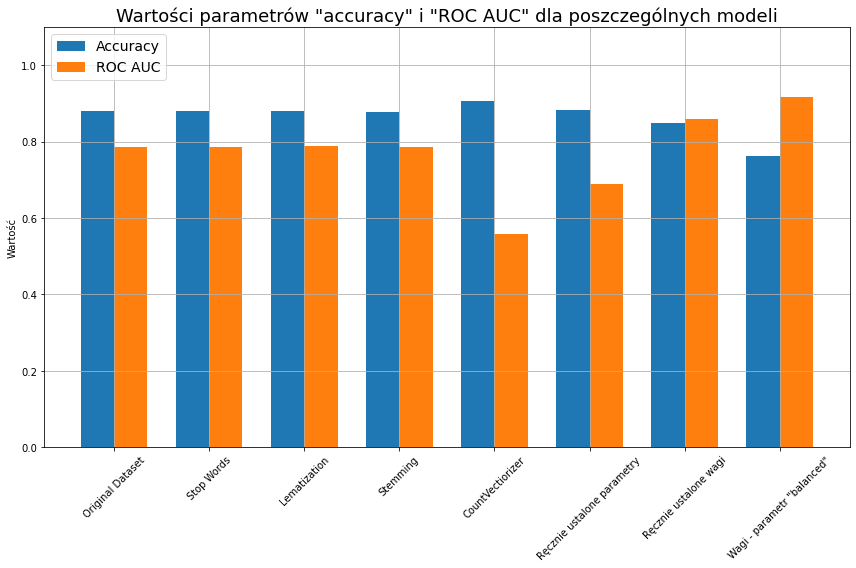

In [340]:
x = np.arange(len(indices))
width = 0.35

fig, ax = plt.subplots(figsize=(12,8))
rects1 = ax.bar(x - width/2, acc, width, label='Accuracy')
rects2 = ax.bar(x + width/2, auc, width, label='ROC AUC')

ax.set_ylabel('Wartość')
ax.set_title('Wartości parametrów "accuracy" i "ROC AUC" dla poszczególnych modeli', fontsize=18)
ax.set_xticks(x)
ax.set_xticklabels(indices, rotation=45)
ax.set_ylim([0, 1.1])
ax.legend(fontsize=14, loc='upper left')
ax.grid(zorder=0)

#ax.bar_label(rects1, padding=3)
#ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

## Precision_score

Funkcja **precision_score** z pakietu *metrics* biblioteki *sklearn* zwraca precyzję danej predykcji obliczoną ze wzoru:

$$Precision=\frac{True Positive}{True Positive + False Positive}$$

Intuicyjnie precyzja jest rozumiana   jako zdolność klasyfikatora do nieoznaczania jako pozytywnej (czyli przydzielonej do danej kategorii) próbki, która jest negatywna (nie przydzielona do tej kategorii).

In [219]:
precision_basic = precision_score(y_test, basic_pred, average=None)
precision_stop = precision_score(y_test, stop_pred, average=None)
precision_lem = precision_score(y_test, lem_pred, average=None)
precision_stem = precision_score(y_test, stem_pred, average=None)
precision_lem2 = precision_score(y_test, lem2_pred, average=None)
precision_lem3 = precision_score(y_test, lem3_pred, average=None)
precision_lem_weighted = precision_score(y_test, clf_weight.predict(X_test_lem_transformed), average=None)
precision_lem_balanced = precision_score(y_test, clf_weight2.predict(X_test_lem_transformed), average=None)

In [221]:
precision = np.concatenate((precision_basic,precision_stop,precision_lem, precision_stem,precision_lem2,precision_lem3,
                           precision_lem_weighted, precision_lem_balanced)
                           , axis=0).reshape(8,6)

In [250]:
colnames = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

precision_df = pd.DataFrame(index=indices, columns=colnames, data=precision)
precision_df

toxic  severe_toxic   obscene    threat  \
Original Dataset            0.575830      0.280059  0.641943  0.413408   
Stop Words                  0.572886      0.282127  0.641158  0.415730   
Lematization                0.568985      0.277126  0.632992  0.345946   
Stemming                    0.567963      0.279211  0.632416  0.361111   
CountVectiorizer            0.896708      0.397849  0.915433  0.200000   
Ręcznie ustalone parametry  0.596646      0.430267  0.701042  0.187755   
Ręcznie ustalone wagi       0.485448      0.220311  0.521958  0.261856   
Wagi - parametr "balanced"  0.453893      0.050280  0.443637  0.024588   

                              insult  identity_hate  
Original Dataset            0.596487       0.573657  
Stop Words                  0.592620       0.579685  
Lematization                0.585839       0.570962  
Stemming                    0.581569       0.567524  
CountVectiorizer            0.788194       0.714286  
Ręcznie ustalone parametry  0.704583       0.345528  
Ręcznie ustalone wagi       0.484790       0.439139  
Wagi - parametr "balanced"  0.364468       0.088370

In [251]:
import seaborn as sns
import matplotlib.pyplot as plt

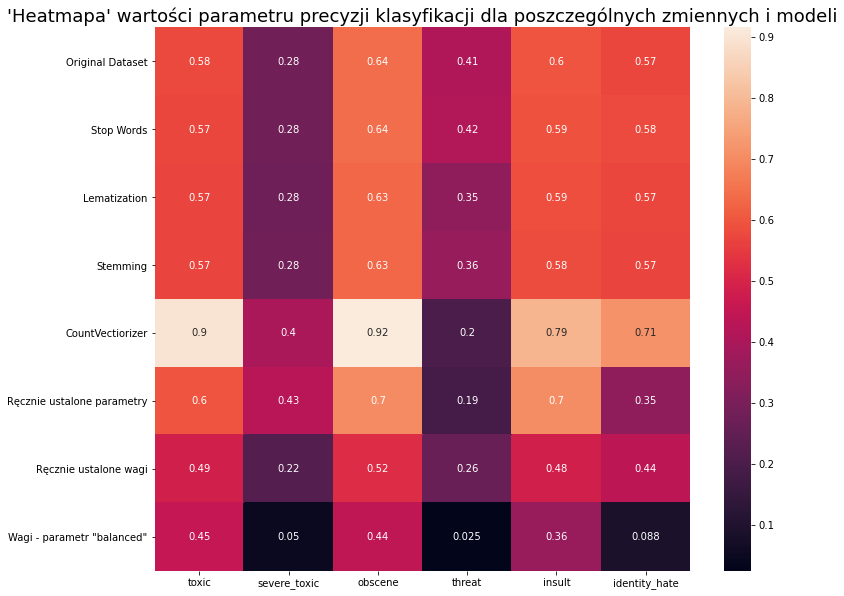

In [326]:
plt.figure(figsize=(12,10))
sns.heatmap(precision_df,
            yticklabels=precision_df.index.values,
            xticklabels=precision_df.columns.values, annot=True)
plt.yticks(rotation=0)
plt.xticks(rotation=0)
plt.title('\'Heatmapa\' wartości parametru precyzji klasyfikacji dla poszczególnych zmiennych i modeli', fontsize=18)
plt.show()

Najmniejsze wartości precyzji możemy zauważyć dla kategorii *severe_toxic* i *threat*. Z kolei porównując precyję modeli, poza klasą *threat* zdecydowanie najlepiej działa model oparty na **regresji logistycznej** i wektoryzacji tekstu za pomocą obiektu **CountVectorizer**. Dla tego modelu najwyższa wartość precyzji wystąpiła dla tekstu po zastosowaniu lematyzacji. 

### Wartość predykcyjna ujemna

$$Negative Predicitve Value =\frac{True Negative}{True Negative + False Negative}$$

Intuicyjnie wyraża prawdopodobieństwo, że ujemny wynik testu jest prawdziwy.

In [253]:
NPV = precision_df.copy()

In [254]:
for i in range(6):
    NPV.iloc[0,i]=precision_score(y_test.iloc[:,i], basic_pred[:,i], average='binary', pos_label=0)
    NPV.iloc[1,i]=precision_score(y_test.iloc[:,i], stop_pred[:,i], average='binary', pos_label=0)
    NPV.iloc[2,i]=precision_score(y_test.iloc[:,i], lem_pred[:,i], average='binary', pos_label=0)
    NPV.iloc[3,i]=precision_score(y_test.iloc[:,i], stem_pred[:,i], average='binary', pos_label=0)
    NPV.iloc[4,i]=precision_score(y_test.iloc[:,i], lem2_pred[:,i], average='binary', pos_label=0)
    NPV.iloc[5,i]=precision_score(y_test.iloc[:,i], lem3_pred[:,i], average='binary', pos_label=0)
    NPV.iloc[6,i]=precision_score(y_test.iloc[:,i], weight_pred[:,i], average='binary', pos_label=0)
    NPV.iloc[7,i]=precision_score(y_test.iloc[:,i], balanced_pred[:,i], average='binary', pos_label=0)

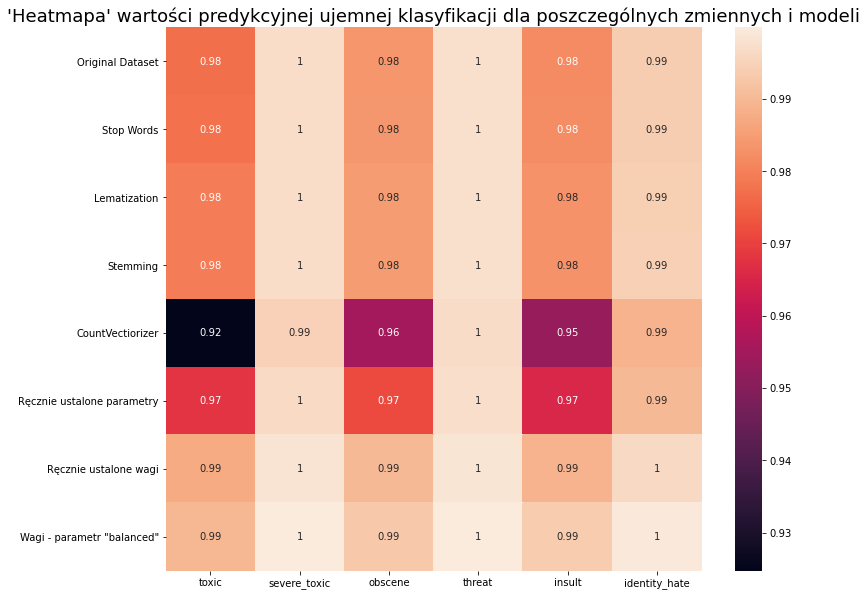

In [325]:
plt.figure(figsize=(12,10))
sns.heatmap(NPV,
            yticklabels=NPV.index.values,
            xticklabels=NPV.columns.values, annot=True)
plt.yticks(rotation=0)
plt.xticks(rotation=0)
plt.title('\'Heatmapa\' wartości predykcyjnej ujemnej klasyfikacji dla poszczególnych zmiennych i modeli', fontsize=18)
plt.show()

Negatywna wartość predykcyjna jest wysoka dla każdego modelu i dla każdej kategorii z tego względu, że dla każdej z klas dużo liczniejsza jest grupa do niej nienależąca niż ta reprezentująca daną klasę.

### Czułość

W przypadku danych niezrównoważonych miara trafności (*accuracy*) jest często złą miarą do oceny modelu. Badając efektywność działania modelu dla takich danych warto obliczyć czułość (*sensitivity*). Wyraża się ona wzorem:

$$Sensitivity =\frac{True Positive}{True Positive + False Negative}$$


In [256]:
recall = precision_df.copy()

In [257]:
for i in range(6):
    recall.iloc[0,i]=recall_score(y_test.iloc[:,i], basic_pred[:,i], average='binary')
    recall.iloc[1,i]=recall_score(y_test.iloc[:,i], stop_pred[:,i], average='binary')
    recall.iloc[2,i]=recall_score(y_test.iloc[:,i], lem_pred[:,i], average='binary')
    recall.iloc[3,i]=recall_score(y_test.iloc[:,i], stem_pred[:,i], average='binary')
    recall.iloc[4,i]=recall_score(y_test.iloc[:,i], lem2_pred[:,i], average='binary')
    recall.iloc[5,i]=recall_score(y_test.iloc[:,i], lem3_pred[:,i], average='binary')
    recall.iloc[6,i]=recall_score(y_test.iloc[:,i], weight_pred[:,i], average='binary')
    recall.iloc[7,i]=recall_score(y_test.iloc[:,i], balanced_pred[:,i], average='binary')

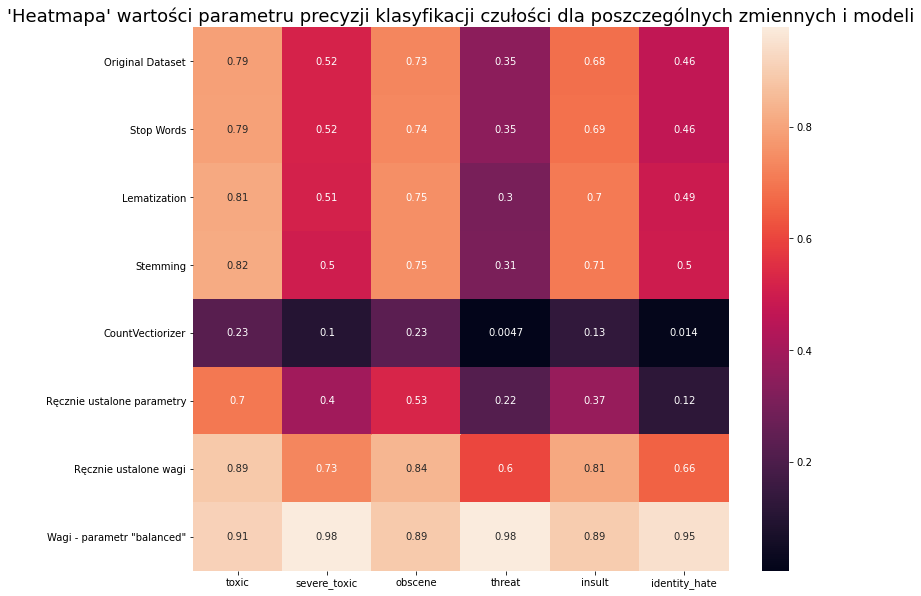

In [324]:
plt.figure(figsize=(12,10))
sns.heatmap(recall,
            yticklabels=recall.index.values,
            xticklabels=recall.columns.values, annot=True)
plt.yticks(rotation=0)
plt.xticks(rotation=0)
plt.title('\'Heatmapa\' wartości parametru precyzji klasyfikacji czułości dla poszczególnych zmiennych i modeli', fontsize=18)
plt.show()

Dla regresji logistycznej wartość parametru jest dosyć wysoka. Szczególnie warto zwrócić uwagę na poprawę wartości parametru dla zmiennych poddanych lematyzacji oraz stemmingowi.

W modelach uwzględniających wagi klas dużo więcej obserwacji zostało przydzielonych do jakieś klasy - stąd relatywnie mała wartość parametru *accuracy* czy *precision*. Jednakże chcąc skutecznie klasyfikować komentarze należące do chociaż jednej kategorii, modele te będą działał lepiej. Można zauważyć to analizując współczynniki czułości (*recall score*), które są zdecydowanie wyższe od pozostałych modeli.

Już w przypadku ręcznie ustawionych wag poprawa jest dosyć duża, jednak zdecydownie najlepsze wyniki osiąga parametr odgórnie ustawiony jako *balanced*.

### F1 score

Współczynnik F1 można zinterpretować jako średnia harmoniczną precyzji i czułości. Osiąga najlepszą wartość przy 1, a najgorszą przy 0. Względny wkład precyzji i czułości w wartość indeksu F1 jest taki sam. Współczynnik jest obliczany ze wzoru:

$$ Współczynnik F1 =2\cdot\frac{precyzja * czułość}{precyzja + czułość}$$


In [259]:
f1_basic = f1_score(y_test, basic_pred, average=None)
f1_stop = f1_score(y_test, stop_pred, average=None)
f1_lem = f1_score(y_test, lem_pred, average=None)
f1_stem = f1_score(y_test, stem_pred, average=None)
f1_lem2 = f1_score(y_test, lem2_pred, average=None)
f1_lem3 = f1_score(y_test,lem3_pred, average=None)
f1_weight = f1_score(y_test,weight_pred, average=None)
f1_balanced = f1_score(y_test,balanced_pred, average=None)

In [260]:
F1 = precision_df.copy()
F1.iloc[0,:] = f1_basic
F1.iloc[1,:] = f1_stop
F1.iloc[2,:] = f1_lem
F1.iloc[3,:] = f1_stem
F1.iloc[4,:] = f1_lem2
F1.iloc[5,:] = f1_lem3
F1.iloc[6,:] = f1_weight
F1.iloc[7,:] = f1_balanced

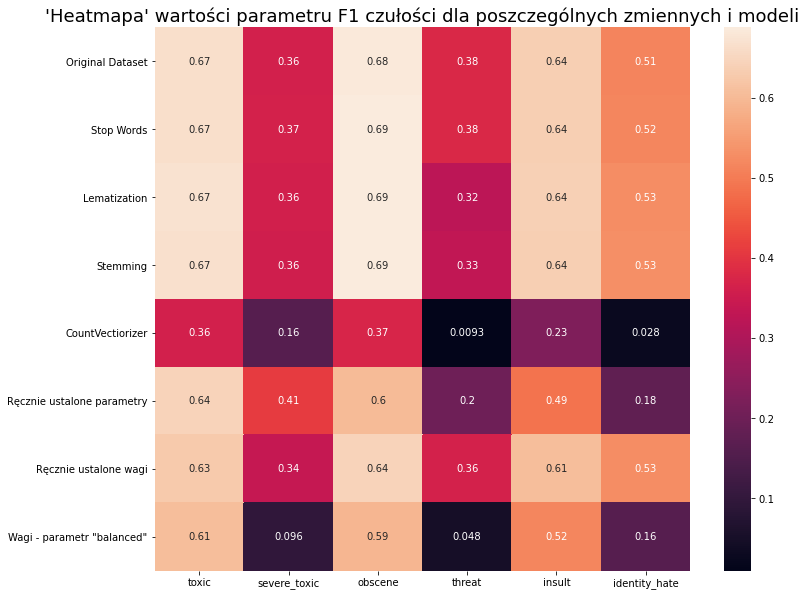

In [323]:
plt.figure(figsize=(12,10))
sns.heatmap(F1,
            yticklabels=F1.index.values,
            xticklabels=F1.columns.values, annot=True)
plt.yticks(rotation=0)
plt.xticks(rotation=0)
plt.title('\'Heatmapa\' wartości parametru F1 czułości dla poszczególnych zmiennych i modeli', fontsize=18)
plt.show()

# Podsumowanie

Po porównaniu wyników różnych modeli, możemy wysunąć dwa bardzo ważne wnioski:

* Czyszczenie i przetwarzanie danych tekstowych korzystnie wpływa, szczególnie przy przewidywaniu komentarzy należących do któreś z kategorii.
* Dla niezbalansowanych danych dużą poprawę jakości predykcji daje ustawienie wag poszczególnym klasom.